**_Results for the tumor growth synthetic dataset_**

In [1]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

**1) Set up client**

In [2]:
mlflow.set_tracking_uri('http://localhost:3335')
client = MlflowClient()

**2) List experiments**

In [3]:
model_names = ['SCIP', 'CIP', 'CT', 'CRN', 'TECDE', 'RMSN', 'G-Net']
experiment_names = [model_name + '/tumor_generator_FINAL' for model_name in model_names]
experiments = {exp.name: exp.experiment_id for exp in client.search_experiments()}

**3) Access all runs within each experiment and extract metrics + params**

In [29]:
metric_names = ['encoder_test_rmse_all', 'decoder_test_rmse_2-step', 'decoder_test_rmse_3-step']

param_names = ['model/name', 'dataset/coeff', 'dataset/seed', 'dataset/num_patients/train', 'dataset/treatment_sequence']
data_dict = {}

for experiment_name in experiment_names:
    if experiment_name in experiments:
        experiment_id = experiments[experiment_name]
        # Get all runs for the experiment
        runs = client.search_runs(experiment_ids=[experiment_id])
        # Extract metrics and parameters
        runs_data = [
            {
                **run.data.metrics,
                **run.data.params,
                'run_id': run.info.run_id
            }
            for run in runs
        ]
        combined_df = pd.DataFrame(runs_data)
        if not combined_df.empty:
            # Filter the DataFrame to only include the desired metrics and parameters
            columns_to_include = ['run_id'] + metric_names + param_names
            filtered_df = combined_df[columns_to_include]
            if experiment_name == 'SCIP/tumor_generator_FINAL_OLD_no_stabilization':
                data_dict['CIP'] = filtered_df
            else:
                data_dict[experiment_name.split("/")[0]] = filtered_df
        else:
            print(f"No runs found for experiment {experiment_name}.")
    else:
        print(f"Experiment {experiment_name} does not exist.")

for model in model_names:
    data_dict[model] = data_dict[model].rename(columns={'encoder_test_rmse_all': '1',
                                                        'decoder_test_rmse_2-step': '2',                               
                                                        'decoder_test_rmse_3-step': '3',
                                                        'dataset/coeff': 'gamma',
                                                        'dataset/num_patients/train': 'N'})
    data_dict[model]['gamma'] = pd.to_numeric(data_dict[model]['gamma'])
    data_dict[model] = data_dict[model][data_dict[model]['gamma'] >= 4]
    data_dict[model] = data_dict[model][data_dict[model]['gamma'] <= 10]

**4) Compute mean and std of RMSEs per model and confounding strength: 1-day ahead predictions**

In [30]:
SCIP_mean_rmse = data_dict['SCIP'].groupby('gamma')[['1']].mean()
SCIP_mean_rmse['model'] = 'SCIP'
SCIP_std_rmse = data_dict['SCIP'].groupby('gamma')[['1']].std()
SCIP_std_rmse['model'] = 'SCIP'

CIP_mean_rmse = data_dict['CIP'].groupby('gamma')[['1']].mean()
CIP_mean_rmse['model'] = 'CIP'
CIP_std_rmse = data_dict['CIP'].groupby('gamma')[['1']].std()
CIP_std_rmse['model'] = 'CIP'

GNet_mean_rmse = data_dict['G-Net'].groupby('gamma')[['1']].mean()
GNet_mean_rmse['model'] = 'G-Net'
GNet_std_rmse = data_dict['G-Net'].groupby('gamma')[['1']].std()
GNet_std_rmse['model'] = 'G-Net'


RMSN_mean_rmse = data_dict['RMSN'].groupby('gamma')[['1']].mean()
RMSN_mean_rmse['model'] = 'RMSN'
RMSN_std_rmse = data_dict['RMSN'].groupby('gamma')[['1']].std()
RMSN_std_rmse['model'] = 'RMSN'


CT_mean_rmse = data_dict['CT'].groupby('gamma')[['1']].mean()
CT_mean_rmse['model'] = 'CT'
CT_std_rmse = data_dict['CT'].groupby('gamma')[['1']].std()
CT_std_rmse['model'] = 'CT'


CRN_mean_rmse = data_dict['CRN'].groupby('gamma')[['1']].mean()
CRN_mean_rmse['model'] = 'CRN'
CRN_std_rmse = data_dict['CRN'].groupby('gamma')[['1']].std()
CRN_std_rmse['model'] = 'CRN'


TECDE_mean_rmse = data_dict['TECDE'].groupby('gamma')[['1']].mean()
TECDE_mean_rmse['model'] = 'TECDE'
TECDE_std_rmse = data_dict['TECDE'].groupby('gamma')[['1']].std()
TECDE_std_rmse['model'] = 'TECDE'

mean_rmse = pd.concat([SCIP_mean_rmse, CIP_mean_rmse, GNet_mean_rmse, RMSN_mean_rmse, CT_mean_rmse, CRN_mean_rmse, TECDE_mean_rmse], axis=0).reset_index()
mean_rmse['gamma'] = mean_rmse['gamma'].astype(float)
mean_rmse = mean_rmse[['model', 'gamma', '1']].rename(columns={'1': 'mean_rmse'})
std_rmse = pd.concat([SCIP_std_rmse, CIP_std_rmse, GNet_std_rmse, RMSN_std_rmse, CT_std_rmse, CRN_std_rmse, TECDE_std_rmse], axis=0).reset_index()
std_rmse = std_rmse[['model', 'gamma', '1']].rename(columns={'1': 'std_rmse'})
std_rmse['N'] = std_rmse['gamma'].astype(float)

**Average RMSE**

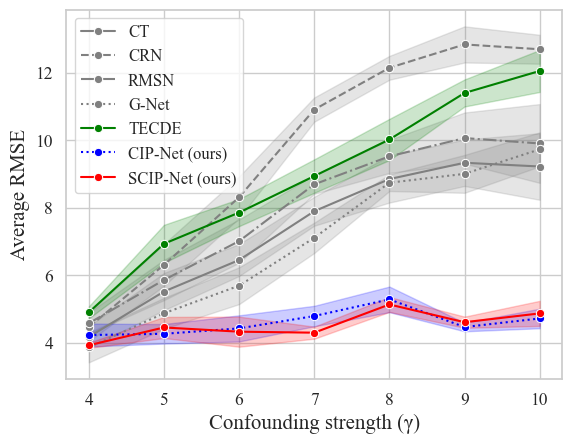

In [33]:
df = pd.merge(mean_rmse, std_rmse, on=['model', 'gamma'], suffixes=('', '_std'))
# Create model order
model_order = ['CT', 'CRN', 'RMSN', 'G-Net','TECDE', 'CIP-Net (ours)' ,'SCIP-Net (ours)']
# Sorting the dataframe
df = df.sort_values(by=['model', 'gamma'])
df['model'] = df['model'].replace('SCIP', 'SCIP-Net (ours)')
df['model'] = df['model'].replace('CIP', 'CIP-Net (ours)')

# Define specific colors and linestyles for each model
model_styles = {
    'CT': {'color': 'grey', 'linestyle': '-'},
    'CRN': {'color': 'grey', 'linestyle': '--'},
    'RMSN': {'color': 'grey', 'linestyle': '-.'},
    'G-Net': {'color': 'grey', 'linestyle': ':'},
    'TECDE': {'color': 'green', 'linestyle': '-'},
    'CIP-Net (ours)': {'color': 'blue', 'linestyle': ':'},  # dotted blue
    'SCIP-Net (ours)': {'color': 'red', 'linestyle': '-'}, # solid blue
}

sns.set(style="whitegrid", font_scale=1.15)
rc('font', **{'family': 'Times New Roman', 'weight': 'normal', 'size': 10})

# Plot each model separately with its specific style
for model in model_order:
    model_df = df[df['model'] == model]
    sns.lineplot(
        data=model_df,
        x='gamma',
        y='mean_rmse',
        label=model,
        color=model_styles[model]['color'],
        linestyle=model_styles[model]['linestyle'],
        marker='o'
    )
    
    # Add shaded area for standard deviation
    plt.fill_between(
        model_df['gamma'],
        model_df['mean_rmse'] - model_df['std_rmse'] / 2,
        model_df['mean_rmse'] + model_df['std_rmse'] / 2,
        color=model_styles[model]['color'],
        alpha=0.2
    )

# Set labels and legend
plt.xlabel('Confounding strength (γ)', fontsize=15)
plt.ylabel('Average RMSE', fontsize=15)
plt.legend(loc='upper left', frameon=True, fontsize=12)
#plt.savefig('../overleaf/figures/results_cancer_sim_window1.pdf')
plt.show()

**5) Compute mean and std of RMSEs per model and confounding strength: 2-days ahead predictions**

In [34]:
SCIP_mean_rmse = data_dict['SCIP'].groupby('gamma')[['2']].mean()
SCIP_mean_rmse['model'] = 'SCIP'
SCIP_std_rmse = data_dict['SCIP'].groupby('gamma')[['2']].std()
SCIP_std_rmse['model'] = 'SCIP'

CIP_mean_rmse = data_dict['CIP'].groupby('gamma')[['2']].mean()
CIP_mean_rmse['model'] = 'CIP'
CIP_std_rmse = data_dict['CIP'].groupby('gamma')[['2']].std()
CIP_std_rmse['model'] = 'CIP'

GNet_mean_rmse = data_dict['G-Net'].groupby('gamma')[['2']].mean()
GNet_mean_rmse['model'] = 'G-Net'
GNet_std_rmse = data_dict['G-Net'].groupby('gamma')[['2']].std()
GNet_std_rmse['model'] = 'G-Net'


RMSN_mean_rmse = data_dict['RMSN'].groupby('gamma')[['2']].mean()
RMSN_mean_rmse['model'] = 'RMSN'
RMSN_std_rmse = data_dict['RMSN'].groupby('gamma')[['2']].std()
RMSN_std_rmse['model'] = 'RMSN'


CT_mean_rmse = data_dict['CT'].groupby('gamma')[['2']].mean()
CT_mean_rmse['model'] = 'CT'
CT_std_rmse = data_dict['CT'].groupby('gamma')[['2']].std()
CT_std_rmse['model'] = 'CT'


CRN_mean_rmse = data_dict['CRN'].groupby('gamma')[['2']].mean()
CRN_mean_rmse['model'] = 'CRN'
CRN_std_rmse = data_dict['CRN'].groupby('gamma')[['2']].std()
CRN_std_rmse['model'] = 'CRN'


TECDE_mean_rmse = data_dict['TECDE'].groupby('gamma')[['2']].mean()
TECDE_mean_rmse['model'] = 'TECDE'
TECDE_std_rmse = data_dict['TECDE'].groupby('gamma')[['2']].std()
TECDE_std_rmse['model'] = 'TECDE'

mean_rmse = pd.concat([SCIP_mean_rmse, CIP_mean_rmse, GNet_mean_rmse, RMSN_mean_rmse, CT_mean_rmse, CRN_mean_rmse, TECDE_mean_rmse], axis=0).reset_index()
mean_rmse['gamma'] = mean_rmse['gamma'].astype(float)
mean_rmse = mean_rmse[['model', 'gamma', '2']].rename(columns={'2': 'mean_rmse'})
std_rmse = pd.concat([SCIP_std_rmse, CIP_std_rmse, GNet_std_rmse, RMSN_std_rmse, CT_std_rmse, CRN_std_rmse, TECDE_std_rmse], axis=0).reset_index()
std_rmse = std_rmse[['model', 'gamma', '2']].rename(columns={'2': 'std_rmse'})
std_rmse['N'] = std_rmse['gamma'].astype(float)

**Average RMSE**

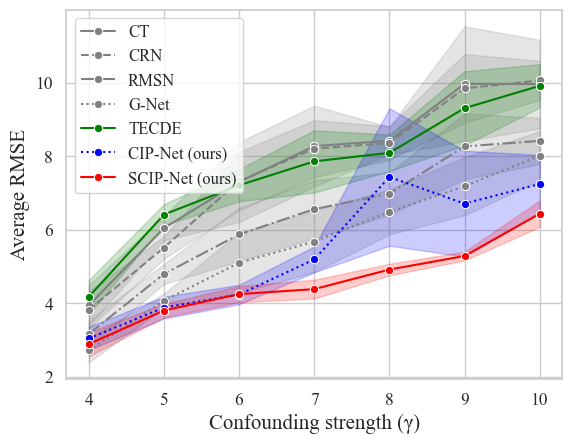

In [35]:
df = pd.merge(mean_rmse, std_rmse, on=['model', 'gamma'], suffixes=('', '_std'))
# Create model order
model_order = ['CT', 'CRN', 'RMSN', 'G-Net','TECDE', 'CIP-Net (ours)' ,'SCIP-Net (ours)']
# Sorting the dataframe
df = df.sort_values(by=['model', 'gamma'])
df['model'] = df['model'].replace('SCIP', 'SCIP-Net (ours)')
df['model'] = df['model'].replace('CIP', 'CIP-Net (ours)')

# Define specific colors and linestyles for each model
model_styles = {
    'CT': {'color': 'grey', 'linestyle': '-'},
    'CRN': {'color': 'grey', 'linestyle': '--'},
    'RMSN': {'color': 'grey', 'linestyle': '-.'},
    'G-Net': {'color': 'grey', 'linestyle': ':'},
    'TECDE': {'color': 'green', 'linestyle': '-'},
    'CIP-Net (ours)': {'color': 'blue', 'linestyle': ':'},  # dotted blue
    'SCIP-Net (ours)': {'color': 'red', 'linestyle': '-'}, # solid blue
}

sns.set(style="whitegrid", font_scale=1.15)
rc('font', **{'family': 'Times New Roman', 'weight': 'normal', 'size': 10})

# Plot each model separately with its specific style
for model in model_order:
    model_df = df[df['model'] == model]
    sns.lineplot(
        data=model_df,
        x='gamma',
        y='mean_rmse',
        label=model,
        color=model_styles[model]['color'],
        linestyle=model_styles[model]['linestyle'],
        marker='o'
    )
    
    # Add shaded area for standard deviation
    plt.fill_between(
        model_df['gamma'],
        model_df['mean_rmse'] - model_df['std_rmse'] / 2,
        model_df['mean_rmse'] + model_df['std_rmse'] / 2,
        color=model_styles[model]['color'],
        alpha=0.2
    )

# Set labels and legend
plt.xlabel('Confounding strength (γ)', fontsize=15)
plt.ylabel('Average RMSE', fontsize=15)
plt.legend(loc='upper left', frameon=True, fontsize=12)
#plt.savefig('../overleaf/figures/results_cancer_sim_window2.pdf')
plt.show()

**6) Compute mean and std of RMSEs per model and confounding strength: 2-days ahead predictions**

In [36]:
SCIP_mean_rmse = data_dict['SCIP'].groupby('gamma')[['3']].mean()
SCIP_mean_rmse['model'] = 'SCIP'
SCIP_std_rmse = data_dict['SCIP'].groupby('gamma')[['3']].std()
SCIP_std_rmse['model'] = 'SCIP'

CIP_mean_rmse = data_dict['CIP'].groupby('gamma')[['3']].mean()
CIP_mean_rmse['model'] = 'CIP'
CIP_std_rmse = data_dict['CIP'].groupby('gamma')[['3']].std()
CIP_std_rmse['model'] = 'CIP'

GNet_mean_rmse = data_dict['G-Net'].groupby('gamma')[['3']].mean()
GNet_mean_rmse['model'] = 'G-Net'
GNet_std_rmse = data_dict['G-Net'].groupby('gamma')[['3']].std()
GNet_std_rmse['model'] = 'G-Net'


RMSN_mean_rmse = data_dict['RMSN'].groupby('gamma')[['3']].mean()
RMSN_mean_rmse['model'] = 'RMSN'
RMSN_std_rmse = data_dict['RMSN'].groupby('gamma')[['3']].std()
RMSN_std_rmse['model'] = 'RMSN'


CT_mean_rmse = data_dict['CT'].groupby('gamma')[['3']].mean()
CT_mean_rmse['model'] = 'CT'
CT_std_rmse = data_dict['CT'].groupby('gamma')[['3']].std()
CT_std_rmse['model'] = 'CT'


CRN_mean_rmse = data_dict['CRN'].groupby('gamma')[['3']].mean()
CRN_mean_rmse['model'] = 'CRN'
CRN_std_rmse = data_dict['CRN'].groupby('gamma')[['3']].std()
CRN_std_rmse['model'] = 'CRN'


TECDE_mean_rmse = data_dict['TECDE'].groupby('gamma')[['3']].mean()
TECDE_mean_rmse['model'] = 'TECDE'
TECDE_std_rmse = data_dict['TECDE'].groupby('gamma')[['3']].std()
TECDE_std_rmse['model'] = 'TECDE'

mean_rmse = pd.concat([SCIP_mean_rmse, CIP_mean_rmse, GNet_mean_rmse, RMSN_mean_rmse, CT_mean_rmse, CRN_mean_rmse, TECDE_mean_rmse], axis=0).reset_index()
mean_rmse['gamma'] = mean_rmse['gamma'].astype(float)
mean_rmse = mean_rmse[['model', 'gamma', '3']].rename(columns={'3': 'mean_rmse'})
std_rmse = pd.concat([SCIP_std_rmse, CIP_std_rmse, GNet_std_rmse, RMSN_std_rmse, CT_std_rmse, CRN_std_rmse, TECDE_std_rmse], axis=0).reset_index()
std_rmse = std_rmse[['model', 'gamma', '3']].rename(columns={'3': 'std_rmse'})
std_rmse['N'] = std_rmse['gamma'].astype(float)

**Average RMSE**

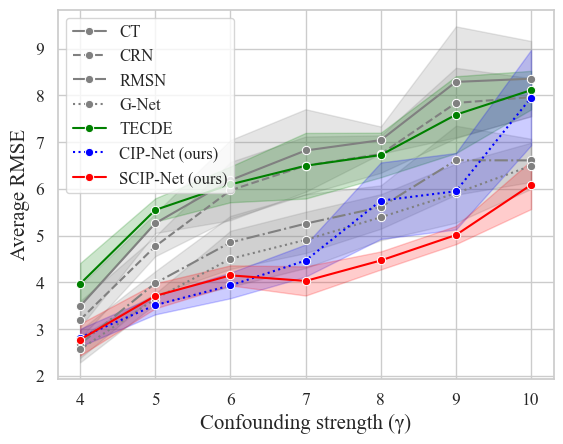

In [37]:
df = pd.merge(mean_rmse, std_rmse, on=['model', 'gamma'], suffixes=('', '_std'))
# Create model order
model_order = ['CT', 'CRN', 'RMSN', 'G-Net','TECDE', 'CIP-Net (ours)' ,'SCIP-Net (ours)']
# Sorting the dataframe
df = df.sort_values(by=['model', 'gamma'])
df['model'] = df['model'].replace('SCIP', 'SCIP-Net (ours)')
df['model'] = df['model'].replace('CIP', 'CIP-Net (ours)')

# Define specific colors and linestyles for each model
model_styles = {
    'CT': {'color': 'grey', 'linestyle': '-'},
    'CRN': {'color': 'grey', 'linestyle': '--'},
    'RMSN': {'color': 'grey', 'linestyle': '-.'},
    'G-Net': {'color': 'grey', 'linestyle': ':'},
    'TECDE': {'color': 'green', 'linestyle': '-'},
    'CIP-Net (ours)': {'color': 'blue', 'linestyle': ':'},  # dotted blue
    'SCIP-Net (ours)': {'color': 'red', 'linestyle': '-'}, # solid blue
}

sns.set(style="whitegrid", font_scale=1.15)
rc('font', **{'family': 'Times New Roman', 'weight': 'normal', 'size': 10})

# Plot each model separately with its specific style
for model in model_order:
    model_df = df[df['model'] == model]
    sns.lineplot(
        data=model_df,
        x='gamma',
        y='mean_rmse',
        label=model,
        color=model_styles[model]['color'],
        linestyle=model_styles[model]['linestyle'],
        marker='o'
    )
    
    # Add shaded area for standard deviation
    plt.fill_between(
        model_df['gamma'],
        model_df['mean_rmse'] - model_df['std_rmse'] / 2,
        model_df['mean_rmse'] + model_df['std_rmse'] / 2,
        color=model_styles[model]['color'],
        alpha=0.2
    )

# Set labels and legend
plt.xlabel('Confounding strength (γ)', fontsize=15)
plt.ylabel('Average RMSE', fontsize=15)
plt.legend(loc='upper left', frameon=True, fontsize=12)
#plt.savefig('../overleaf/figures/results_cancer_sim_window3.pdf')
plt.show()